# Data Utility Learning

This notebook introduces **Data Utility Learning**, a method of approximating Data Shapley values by learning to estimate the utility function.

The idea is to employ a model to learn the performance of the learning algorithm of interest on unseen data combinations (i.e. subsets of the dataset). The method was originally described in *Wang, Tianhao, Yu Yang, and Ruoxi Jia. [Improving Cooperative Game Theory-Based Data Valuation via Data Utility Learning](https://doi.org/10.48550/arXiv.2107.06336). arXiv, 2022*.

<div class="alert alert-warning">
**Warning:** Work on Data Utility Learning is preliminary. It remains to be seen when or whether it can be put effectively into application. For this further testing and benchmarking are required.
</div>

Recall the definition of Shapley value $v_u(i)$ for data point $i$:

\begin{equation}
v_u(i) = \frac{1}{n} \sum_{S \subseteq N \setminus \{i\}} \binom{n-1}{|S|}^{-1} [u(S \cup \{i\}) − u(S)] ,
\tag{1}
\label{eq:shapley-def}
\end{equation}

where $N$ is the set of all indices in the training set and $u$ is the utility. To avoid the exponential cost of computing this sum, we set to learn a surrogate model for $u$.

In Data Utility Learning, we start by sampling so-called **utility samples** to form a training set  $S_\operatorname{train}$ for our utility model. Each utility sample is a tuple consisting of a subset of indices $S_j$ in the dataset and its utility $u(S_j)$:

$$\mathcal{S}_\operatorname{train} = \{(S_j, v(S_j): j = 1 , ..., m_\operatorname{train}\}$$

where $m_\operatorname{train}$ denotes the *training budget* for the learned utility function.

The subsets are then transformed into boolean vectors $\phi$ in which a $1$ at index $k$ means that the $k$-th sample of the dataset is present in the subset:

$$S_j \mapsto \phi_j \in \{ 0, 1 \}^{N}$$

We fit a regression model $\tilde{u}$, called **data utility model**, on $\mathcal{S}_\operatorname{train}$ and use it to avoid computing the utility for any $S_j \notin \mathcal{S}_\operatorname{train}$:

$$\tilde{u} : \{ 0, 1 \}^{N} \rightarrow \mathbb{R}. $$

The main assumption is that it is much faster to fit and use $\tilde{u}$ than it is to compute $u$ and that for most $i$, $v_\tilde{u}(i) \approx v_u(i)$ in some sense.

## Setup

We begin by importing the main libraries and setting some defaults.

<div class="alert alert-info">

If you are reading this in the documentation, some boilerplate (including most plotting code) has been omitted for convenience.

</div>

In [1]:
%load_ext autoreload

In [2]:
%autoreload
%matplotlib inline

import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import product
from sklearn.svm import LinearSVC as _LinearSVC
from sklearn.datasets import load_iris
from sklearn.neural_network import MLPRegressor
from sklearn.exceptions import ConvergenceWarning
from tqdm.auto import tqdm

plt.ioff()  # Prevent jupyter from automatically plotting
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams["font.size"] = 15
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15
random_state = 24

is_CI = os.environ.get("CI")
enable_cache = not is_CI

if is_CI:
    train_size = 5
    training_budget_values = np.arange(2, 10, 2)
    n_iterations = 1
else:
    train_size = 15
    training_budget_values = np.arange(100, 8000, 250)
    n_iterations = 10

random.seed(random_state)
np.random.seed(random_state)

from warnings import simplefilter


class LinearSVC(_LinearSVC):
    def fit(self, X, y, sample_weight=None):
        # We inherit to be able to ignore warnings in ray workers
        simplefilter("ignore", category=ConvergenceWarning)
        return super().fit(X, y)

As is the case with all other Shapley methods, the main entry point is the function [compute_shapley_values()](../pydvl/shapley.rst#pydvl.shapley.compute_shapley_values), which provides a facade to all algorithms in this family. We use it with the usual classes [Dataset](../pydvl/utils/dataset.rst#pydvl.utils.dataset.Dataset) and [Utility](../pydvl/utils/utility.rst#pydvl.utils.utility.Utility). In addition, we must import the core class for learning a utility, [DataUtilityLearning](../pydvl/utils/utility.rst#pydvl.utils.utility.DataUtilityLearning).

In [3]:
from pydvl.utils import (
    Dataset,
    Utility,
    DataUtilityLearning,
    top_k_value_accuracy,
    available_cpus,
)
from pydvl.reporting.plots import shaded_mean_std
from pydvl.shapley import compute_shapley_values

## Dataset

Following the paper, we take 15 samples (10%) from the [Iris dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html) and compute their Data Shapley values by using all the remaining samples as test set for computing the utility, which in this case is accuracy.

In [4]:
dataset = Dataset.from_sklearn(
    load_iris(), train_size=0.1, random_state=random_state, stratify=True
)

We verify that, as in the paper, if we fit a Support-Vector Classifier to the training data, we obtain an accuracy of around 92%:

In [5]:
model = LinearSVC()
model.fit(dataset.x_train, dataset.y_train)
print(f"Mean accuracy: {100 * model.score(dataset.x_test, dataset.y_test):0.2f}%")

Mean accuracy: 92.59%



## Data Shapley

We start by defining the utility using the model and computing the exact Data Shapley values by definition $\ref{eq:shapley-def}$.

In [6]:
utility = Utility(model=model, data=dataset, enable_cache=enable_cache)

In [7]:
df = compute_shapley_values(
    u=utility,
    mode="combinatorial_exact",
    n_jobs=min(len(dataset), available_cpus()),
    progress=False,  # Does not display correctly in a notebook
)
df = df.rename(columns={"data_value": "exact"})

2022-10-18 22:12:37,742	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


We now estimate the Data Shapley values using the [DataUtilityLearning](../pydvl/utils/utility.rst#pydvl.utils.utility.DataUtilityLearning) wrapper. This class wraps a [Utility](../pydvl/utils/utility.rst#pydvl.utils.utility.Utility) and delegates calls to it, up until a given budget. Every call yields a utility sample which is saved under the hood for training of the given utility model. Once the budget is exhausted, `DataUtilityLearning` fits the model to the utility samples and all subsequent calls use the learned model to predict the wrapped utility instead of delegating to it.

For the utility model we follow the paper and use a fully connected neural network. To train it we use a total of `training_budget` utility samples. We repeat this multiple times for each training budget.

In [8]:
mlp_kwargs = dict(
    hidden_layer_sizes=(20, 10),
    activation="relu",
    solver="adam",
    learning_rate_init=0.001,
    batch_size=32,
    max_iter=800,
)

print(
    f"Doing {n_iterations} runs for each of {len(training_budget_values)} different training budgets."
)

pbar = tqdm(
    product(range(n_iterations), training_budget_values),
    total=n_iterations * len(training_budget_values),
)
for idx, budget in pbar:
    pbar.set_postfix_str(f"Run {idx} for training budget: {budget}")
    dul_utility = DataUtilityLearning(
        u=utility, training_budget=budget, model=MLPRegressor(**mlp_kwargs)
    )

    dul_df = compute_shapley_values(
        u=dul_utility,
        mode="truncated_montecarlo",
        n_jobs=min(len(dataset), available_cpus()),
        progress=False,
        max_iterations=max(training_budget_values),
    )
    dul_df = dul_df.rename(columns={"data_value": f"{budget}_{idx}"})
    df = pd.concat([df, dul_df], axis=1)

df = df.drop("data_value_std", axis=1);

Doing 10 runs for each of 32 different training budgets.


Next we compute the $l_1$ error across runs for the different training budgets and plot mean and standard deviation. We obtain results analogous to Figure 1 of the paper and verify that the method indeed works for estimating the Data Shapley values (at least in this context). Note that we use an exact computation of the value instead of a Monte Carlo approximation as they do.

In [9]:
errors = np.zeros((len(training_budget_values), n_iterations), dtype=float)
accuracies = np.zeros((len(training_budget_values), n_iterations), dtype=float)

top_k = 3

for i, budget in enumerate(training_budget_values):
    for j in range(n_iterations):
        y_true = df["exact"].values
        y_estimated = df[f"{budget}_{j}"].values
        errors[i, j] = np.linalg.norm(y_true - y_estimated, ord=2)
        accuracies[i, j] = top_k_value_accuracy(y_true, y_estimated, k=top_k)

error_from_mean = np.linalg.norm(df["exact"].values - df["exact"].values.mean(), ord=2)

In [10]:
ax = shaded_mean_std(
    errors.transpose(),
    abscissa=training_budget_values,
    num_std=1,
    xlabel="$m_\\operatorname{train}$",
    ylabel="$L_2$ Error",
    label="Estimated values",
)
ax.hlines(
    error_from_mean,
    training_budget_values.min(),
    training_budget_values.max(),
    "indianred",
    label="Error of mean of exact values",
)
ax.legend();

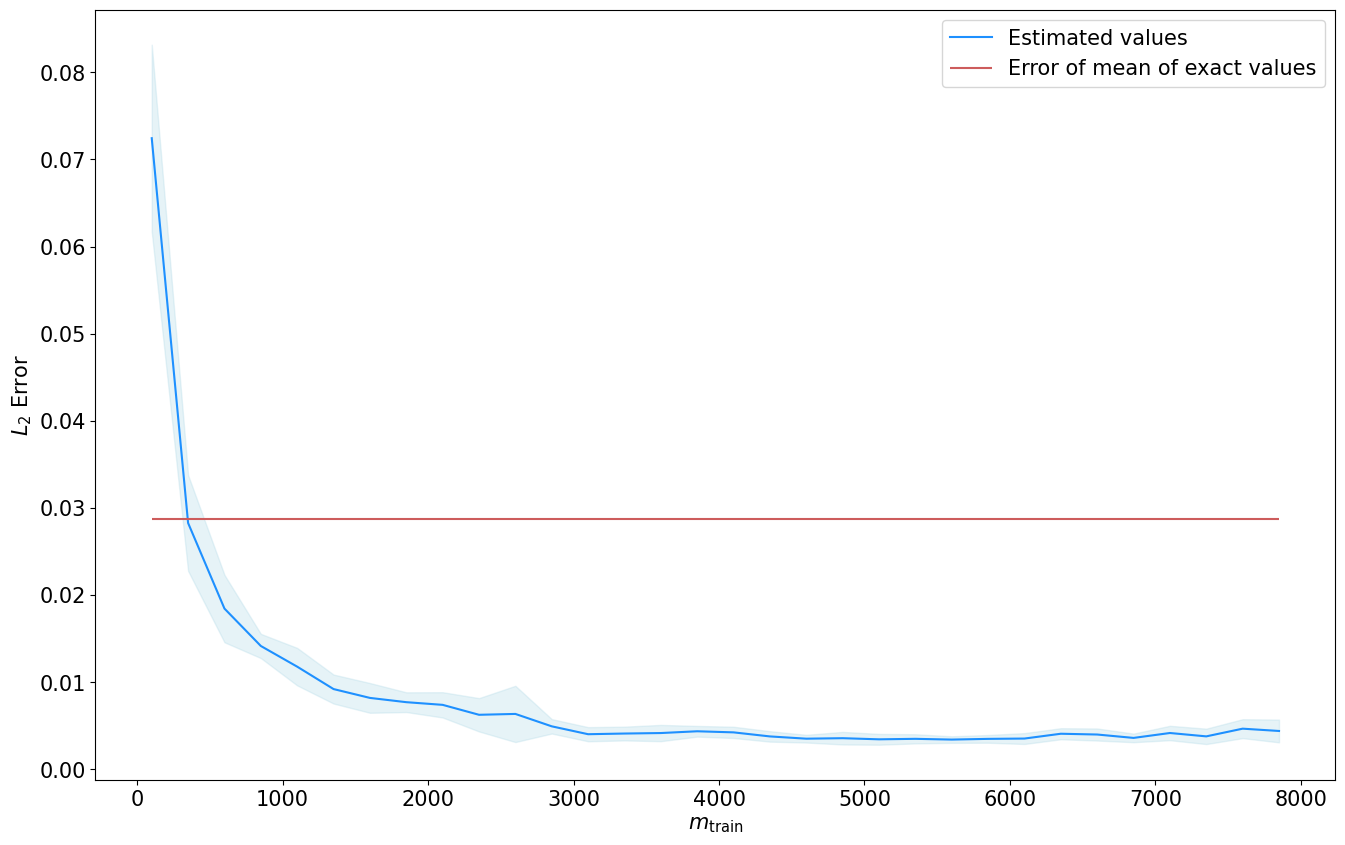

In [11]:
plt.show()

Let us next look at how well the ranking of values resulting from using the surrogate $\tilde{u}$ matches the ranking by the exact values. For this we fix $k=3$ and consider the $k$ samples with the highest value according to $\tilde{u}$ and $u$:

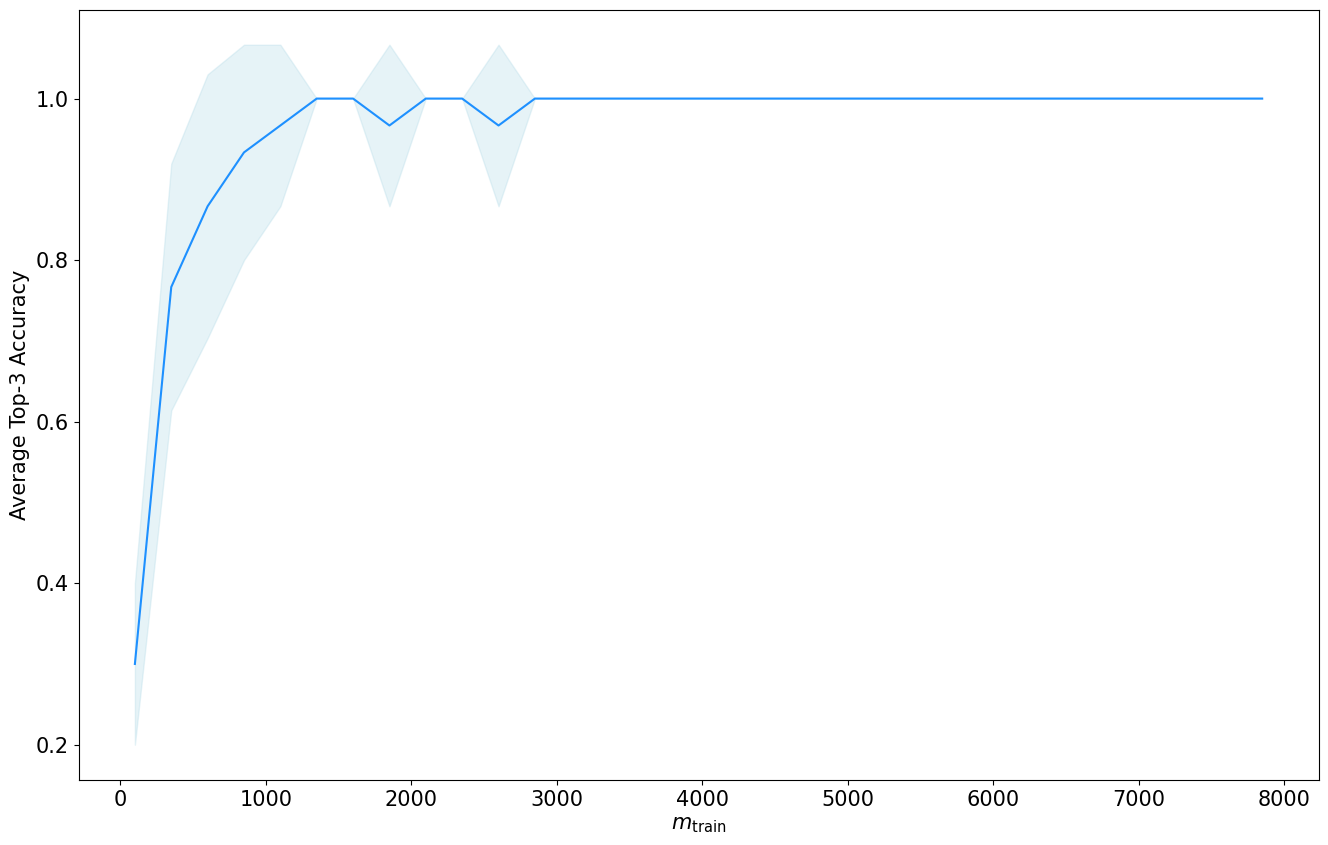

In [12]:
shaded_mean_std(
    accuracies.transpose(),
    abscissa=training_budget_values,
    mean_color="dodgerblue",
    shade_color="lightblue",
    xlabel="$m_\\operatorname{train}$",
    ylabel=f"Average Top-{top_k} Accuracy",
);

Finally, for each sample, we look at the distance of the estimates to the exact value across runs. Boxes are centered at the 50th percentile with wiskers at the 25th and 75th. We plot relative distances, as a percentage. We observe a general tendency to underestimate the value:

In [13]:
fig, ax = plt.subplots(figsize=(18, 12))
distances = 100 * df.loc[:, df.columns != "exact"].sub(df.exact, axis="index").div(
    df.exact, axis="index"
)
distances.transpose().boxplot(column=distances.index.values.tolist(), ax=ax)
ax.hlines(0.0, 0, distances.index.max() + 2, "indianred")
ax.set_xlim((0, distances.index.max() + 2))
# Display 96% of the data
ax.set_ylim(
    (
        distances.transpose().quantile(0.02).min(),
        distances.transpose().quantile(0.98).max(),
    )
)

ax.set_xlabel("Index")
ax.set_ylabel("% deviation from the exact value");

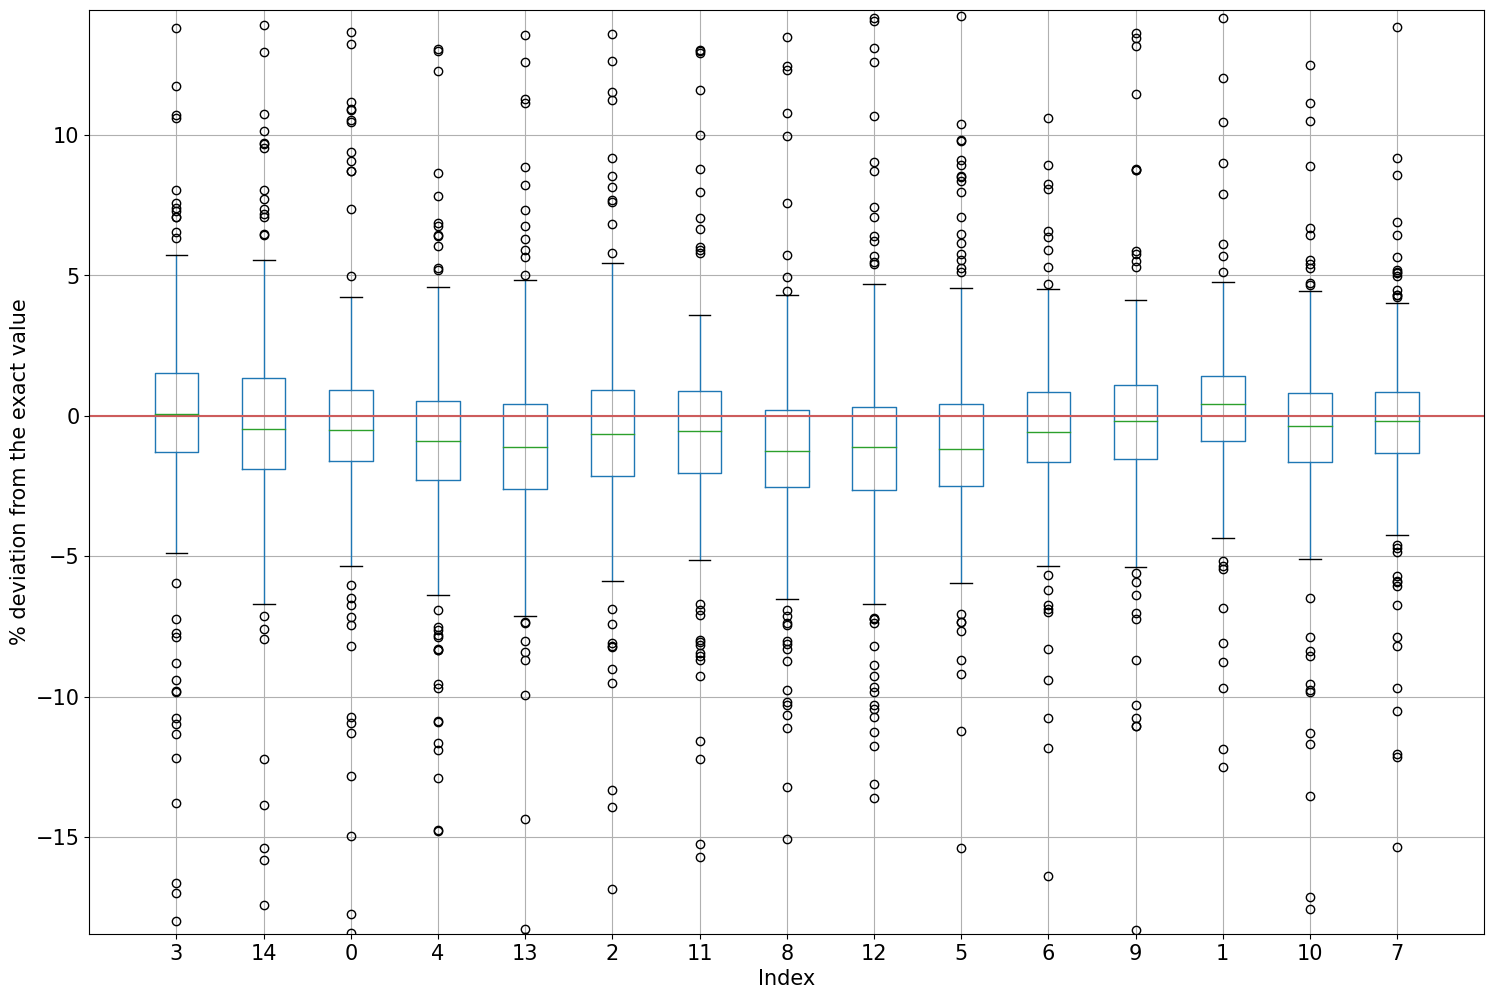

In [14]:
plt.show()

## Evaluation on anomalous data

One interesting way to assess the Data Utility Learning approach is to corrupt some data and monitor how the value changes. To do this, we will take the sample with the highest score and change its label.

In [15]:
highest_value_index = df.index[df["exact"].argmax()]
y_train_corrupted = dataset.y_train.copy()
y_train_corrupted[highest_value_index] = (
    y_train_corrupted[highest_value_index] + 1
) % 3

corrupted_dataset = Dataset(
    x_train=dataset.x_train,
    y_train=y_train_corrupted,
    x_test=dataset.x_test,
    y_test=dataset.y_test,
)

We retrain the model on the new dataset and verify that the accuracy decreases:

In [16]:
model = LinearSVC()
model.fit(dataset.x_train, y_train_corrupted)
print(f"Mean accuracy: {100 * model.score(dataset.x_test, dataset.y_test):0.2f}%")

Mean accuracy: 82.96%


Finally, we recompute the values of all samples using the exact method and the best training budget previously obtained and then plot the resulting scores.

<div class="alert alert-info">

Notice the argument `enable_cache=False` when constructing `utility`: because we have changed some samples in the training set, the utility must be evaluated again on all possible subsets of samples.

</div>

In [17]:
best_training_budget = training_budget_values[errors.mean(axis=1).argmin()]

utility = Utility(
    model=LinearSVC(),
    data=corrupted_dataset,
    enable_cache=False,
)

df_corrupted = compute_shapley_values(
    u=utility,
    mode="combinatorial_exact",
    n_jobs=min(len(dataset), available_cpus()),
    progress=False,
)
df_corrupted = df_corrupted.rename(columns={"data_value": "exact"})

dul_utility = DataUtilityLearning(
    u=utility, training_budget=best_training_budget, model=MLPRegressor(**mlp_kwargs)
)

dul_df = compute_shapley_values(
    u=dul_utility,
    mode="combinatorial_montecarlo",
    n_jobs=min(len(dataset), available_cpus()),
    max_iterations=best_training_budget,  # beyond this, DUL kicks in anyway
    progress=False,
)
dul_df = dul_df.rename(columns={"data_value": "estimated"})
df_corrupted = pd.concat([df_corrupted, dul_df], axis=1)

We can see in the figure that both methods assign the lowest value to the sample with the corrupted label.

In [18]:
fig, ax = plt.subplots()
df_corrupted.plot(
    y=["exact", "estimated"], kind="bar", ax=ax, color=["dodgerblue", "indianred"]
)
ax.set_xlabel("Index")
ax.set_ylabel("Data Shapley value")
plt.legend(["Exact", "Estimated"]);

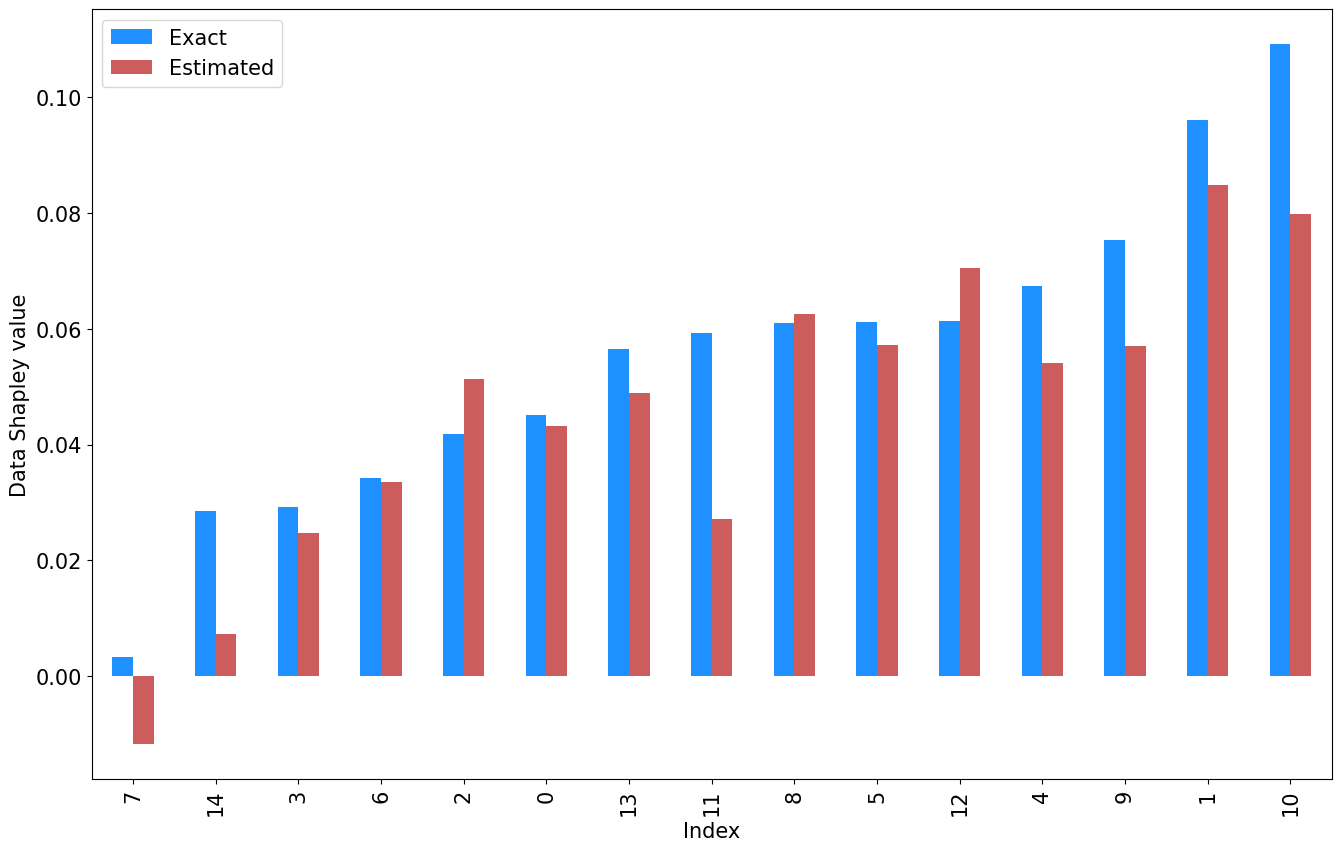

In [19]:
plt.show()

<div class="alert alert-warning">
As mentioned above, despite the previous results, this work is preliminary and the usefulness of Data Utility Learning remains to be tested in practice.
</div>
